# Project: Predicting Stock Price & Return  
## 3. Feature Creation and Random Forest Classifier
Data source include: Alphavantage free API, Bank of Canada, Google Trends

In this notebook I create target variable and feature varibales, feed them into the Random Forest Classifier, and compare different solutions to find an optimized way.  

I take steps as following:
* First I create a discret target variable by converting the continuous 5d return into 5 equally divided bins using qcut.     
* Then I create feature varibales like SMA (Simple Moving Average) and RSI (Relative Strength Index) for stock prices and volums.   
* I searched the best parameters for the Random Forest Classifier and trained the first model. The result is not good.  
* I tried the second way of creating target. I binned the data using the same method of boxplot. The result is not good either.  
* I tried the third way of creating a target variable: 20 return into a binary code. In other word, the model will tell us whether the price will go up or down in the next 20 business days.   

At last, the Random Forest Classifier gives a acceptable result and it proves that our assumption is valid.

Ver 2.0  
Add the second way of feature engineering: 20d return in 2 levels  
Ver 1.0  
Remove unecessary content  
Ver 0.4  
Change the target to return-level (discrete value) and use RandomForestClassifier. Get the feature importance chart  
Ver 0.3  
Try to filter the outliers   
Ver 0.2  
Use loblaws price only to construct features and try linear regression, random forest regression, and neuro networks  
Ver 0.1  
Explore the features, plot the histgram and correlations

## Table of Content  
[0. Import packages](#0)  
[1. Create target: 5 day return level, 5 bins qcut](#1)  
[2. Create features](#2)  
[3. Create train and test set](#3)  
[4. Model training (Random Forest Classifier)](#4)  
[5. Model evaluation](#5)  
[6. Create target: 5 day return level, boxplot](#6)  
[7. Create target: 20 day return level, binary](#7)

<a class="anchor" id="0"></a>
#### 0.Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import talib

In [2]:
#let the notebook display full length of the data columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

<a class="anchor" id="1"></a>
#### 1. Create target

In [3]:
df = pd.read_csv("data/data_transformed.csv", parse_dates=['date'], index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4361 entries, 2003-01-02 to 2019-10-25
Data columns (total 21 columns):
loblaw_price           4361 non-null float64
loblaw_volume          4361 non-null float64
metro_price            4361 non-null float64
metro_volume           4361 non-null float64
empa_price             4361 non-null float64
empa_volume            4361 non-null float64
gwl_price              4361 non-null float64
gwl_volume             4361 non-null float64
atd_price              4361 non-null float64
atd_volume             4361 non-null float64
tsx_price              4361 non-null float64
tsx_volume             4361 non-null float64
sp500_price            4361 non-null float64
sp500_volume           4361 non-null float64
BCPI                   4361 non-null float64
CPI                    4361 non-null float64
bank_interest          4361 non-null float64
CEER                   4361 non-null float64
trend_grocery_store    4109 non-null float64
trend_loblaws       

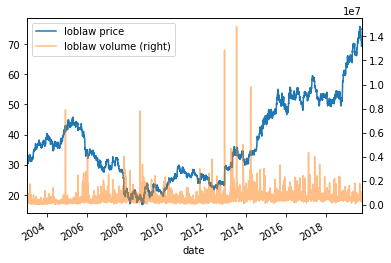

In [4]:
df['loblaw_price'].plot(label = 'loblaw price', legend = True)
df['loblaw_volume'].plot(secondary_y=True, alpha=0.5, label = 'loblaw volume' , legend = True)
plt.show()

In [5]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)
df['loblaws_5d_return_level'] = pd.qcut(df['loblaw_5d_future_pct'], 5, labels=False)


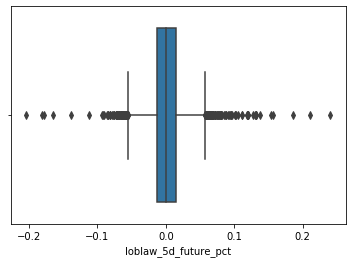

In [6]:
sns.boxplot(df['loblaw_5d_future_pct'])
plt.show()

In [7]:
df['loblaw_5d_future_pct'].quantile(0.2),df['loblaw_5d_future_pct'].quantile(0.4), df['loblaw_5d_future_pct'].quantile(0.6), df['loblaw_5d_future_pct'].quantile(0.8)

(-0.01709254024315221,
 -0.0044455447676045035,
 0.005142380306665251,
 0.019442564255033767)

In [8]:
df.loblaws_5d_return_level.value_counts()

0.0    872
4.0    871
3.0    871
2.0    871
1.0    871
Name: loblaws_5d_return_level, dtype: int64

<a class="anchor" id="2"></a>
#### 2. Create features

In [9]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']


In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(4104, 94)

In [12]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0210,1534500.0,4.9414,23640.0,76.6883,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.4905,-0.015477,1.0,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025713,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037303,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9477,171600.0,4.8872,23703.0,75.3130,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,39.7979,-0.004144,2.0,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004657,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014706,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0320,2180700.0,4.8330,265395.0,74.9346,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.3132,-0.014084,1.0,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014289,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0413,438000.0,4.8421,62139.0,75.3494,120100.0,1.3094,4084548.0,8388.5000,238648300.0,

In [13]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-14,72.805,437050.0,56.29565,505550.0,35.025,501072.0,109.77,104600.0,39.505,1352527.0,16416.7998,206539800.0,2966.1499,2.557020e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,71.42,-0.019023,0.0,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.030688,0.113743,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.028375,-0.005095,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.015516,-0.117595,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.048624,0.140880,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.021669,0.085393,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.000305,0.066937,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,0.009310,-0.007817
2019-10-15,72.600,446100.0,56.38530,627000.0,34.920,386557.0,109.30,107100.0,39.680,1290026.0,16418.4004,212333000.0,2995.6799,3.340740e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,70.77,-0.025207,0.0,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.019316,-0.026214,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.019069,0.032109,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.011486,-0.134033,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.038991,0.054902,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.008743,-0.085273,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,0.007635,0.017875,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,0.035471,0.025164
2019-10-16,71.620,716200.0,55.85730,435900.0,34.700,805510.0,109.22,170900.0,39.580,1623424.0,16427.1992,165968300.0,2989.6899,3.222570e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,69.85,-0.024714,0.0,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.034120,0.053460,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.029096,0.015199,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.020448,0.031480,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.034985,0.275356,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.031800,-0.038056,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,0.002888,0.004483,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,0.024077,0.055607
2019-10-17,71.500,528200.0,56.02660,700600.0,35.130,576685.0,109.28,120000.0,39.170,1868090.0,16426.3008,168397700.0,2997.9500,3.115960e+09,432.33,

In [14]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [15]:
features = df[feature_names]
targets = df[['loblaws_5d_return_level']].values.ravel()

<a class="anchor" id="3"></a>
#### 3. Create train and test set

In [16]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [17]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3078, 84) (3078,)
(1026, 84) (1026,)


<a class="anchor" id="4"></a>
#### 4. Model training

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [19]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.1705653021442495 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 5}


In [20]:
rfc= RandomForestClassifier(n_estimators=200, max_features=64, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.35477582846003897
0.14619883040935672


<a class="anchor" id="5"></a>
#### 5. Model evaluation

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [22]:
accuracy_score(test_targets, predicts)

0.14619883040935672

In [23]:
cm = confusion_matrix(test_targets, predicts)

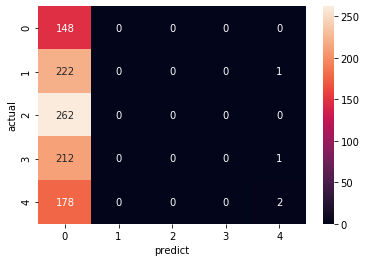

In [24]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

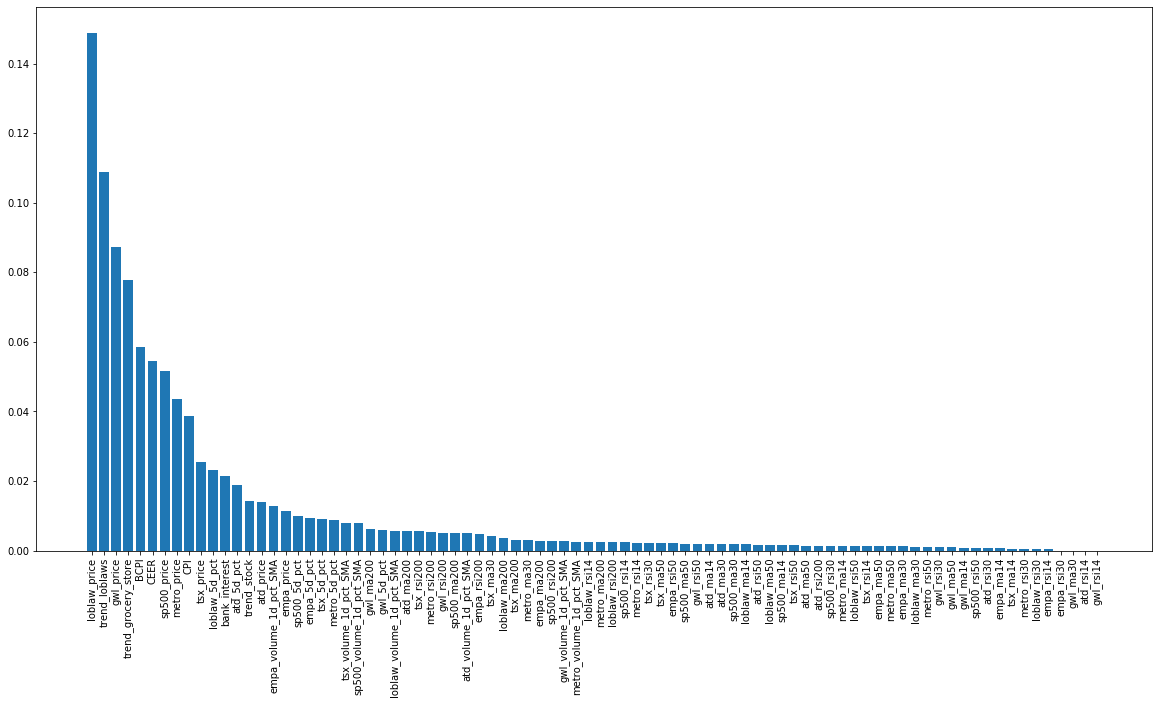

In [25]:
# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.figure(figsize=(20,10))
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

<a class="anchor" id="6"></a>
#### 6. Try the second way of creating targets

In [26]:
df = pd.read_csv("data/data_transformed.csv", parse_dates=['date'], index_col='date')

In [27]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)

In [28]:
Q1 = df['loblaw_5d_future_pct'].quantile(0.25)
Q3 = df['loblaw_5d_future_pct'].quantile(0.75)
IQR = Q3 - Q1

df['loblaws_5d_return_level'] = df['loblaw_5d_future_pct'].apply(lambda x: 0 if x < (Q1 - 1.5 * IQR) 
                                                                else 1 if (Q1 - 1.5 * IQR) < x < Q1
                                                                else 2  if Q1 < x < Q3
                                                                else 3  if Q3 < x < (Q3 + 1.5 * IQR) 
                                                                else 4)

In [29]:
df['loblaws_5d_return_level'].value_counts()

2    2178
1    1014
3    993 
4    101 
0    75  
Name: loblaws_5d_return_level, dtype: int64

In [30]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']

In [31]:
df.dropna(inplace=True)

In [32]:
df.shape

(4104, 94)

In [33]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0210,1534500.0,4.9414,23640.0,76.6883,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.4905,-0.015477,1,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025713,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037303,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9477,171600.0,4.8872,23703.0,75.3130,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,39.7979,-0.004144,2,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004657,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014706,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0320,2180700.0,4.8330,265395.0,74.9346,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.3132,-0.014084,1,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014289,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0413,438000.0,4.8421,62139.0,75.3494,120100.0,1.3094,4084548.0,8388.5000,238648300.0,1126.3

In [34]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-14,72.805,437050.0,56.29565,505550.0,35.025,501072.0,109.77,104600.0,39.505,1352527.0,16416.7998,206539800.0,2966.1499,2.557020e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,71.42,-0.019023,1,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.030688,0.113743,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.028375,-0.005095,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.015516,-0.117595,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.048624,0.140880,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.021669,0.085393,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,-0.000305,0.066937,1.023502,42.500780,1.015697,52.124510,0.997824,54.890753,0.928491,56.180206,0.009310,-0.007817
2019-10-15,72.600,446100.0,56.38530,627000.0,34.920,386557.0,109.30,107100.0,39.680,1290026.0,16418.4004,212333000.0,2995.6799,3.340740e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,70.77,-0.025207,1,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.019316,-0.026214,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.019069,0.032109,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.011486,-0.134033,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.038991,0.054902,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,-0.008743,-0.085273,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,0.007635,0.017875,1.023362,41.074726,1.018459,51.313193,1.001768,54.367541,0.931990,56.034505,0.035471,0.025164
2019-10-16,71.620,716200.0,55.85730,435900.0,34.700,805510.0,109.22,170900.0,39.580,1623424.0,16427.1992,165968300.0,2989.6899,3.222570e+09,432.33,136.8,3.95,117.75,80.0,34.0,64.0,69.85,-0.024714,1,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.034120,0.053460,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.029096,0.015199,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.020448,0.031480,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.034985,0.275356,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,-0.031800,-0.038056,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,0.002888,0.004483,1.033934,35.024542,1.031543,47.645715,1.016332,51.951935,0.945554,55.344891,0.024077,0.055607
2019-10-17,71.500,528200.0,56.02660,700600.0,35.130,576685.0,109.28,120000.0,39.170,1868090.0,16426.3008,168397700.0,2997.9500,3.115960e+09,432.33,136.8,

In [35]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [36]:
features = df[feature_names]
targets = df[['loblaws_5d_return_level']].values.ravel()

In [37]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [38]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3078, 84) (3078,)
(1026, 84) (1026,)


In [39]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [40]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.580896686159844 {'random_state': 42, 'n_estimators': 200, 'max_features': 32, 'max_depth': 3}


In [41]:
rfc= RandomForestClassifier(n_estimators=200, max_features=4, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.4808317089018843
0.5799220272904484


In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [43]:
cm = confusion_matrix(test_targets, predicts)

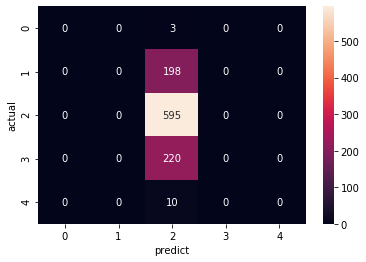

In [44]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

<a class="anchor" id="7"></a>
#### 7. Try the third way of creating targets

In [45]:
df = pd.read_csv("data/data_transformed.csv", parse_dates=['date'], index_col='date')

In [46]:
df['loblaw_20d_future'] = df['loblaw_price'].shift(-20)
df['loblaw_20d_future_pct'] = df['loblaw_20d_future'].pct_change(20)
df['loblaws_20d_return_level'] = pd.qcut(df['loblaw_20d_future_pct'], 2, labels=False)

In [47]:
df['loblaw_20d_future_pct'].quantile(0.5)

0.002456489285197261

In [48]:
df['loblaws_20d_return_level'].value_counts()

0.0    2171
1.0    2170
Name: loblaws_20d_return_level, dtype: int64

In [49]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']

In [50]:
df.dropna(inplace=True)

In [51]:
df.shape

(4089, 94)

In [52]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_20d_future,loblaw_20d_future_pct,loblaws_20d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0210,1534500.0,4.9414,23640.0,76.6883,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.3900,-0.017982,0.0,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025713,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037303,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9477,171600.0,4.8872,23703.0,75.3130,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,38.8698,-0.027367,0.0,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004657,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014706,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0320,2180700.0,4.8330,265395.0,74.9346,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.1654,-0.017791,0.0,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014289,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0413,438000.0,4.8421,62139.0,75.3494,120100.0,1.3094,4084548.0,8388.5000,238648300

In [53]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_20d_future,loblaw_20d_future_pct,loblaws_20d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-23,75.05,639500.0,57.3419,339700.0,35.8683,268245.0,112.07,190100.0,41.310,1387844.0,16867.1992,168552700.0,2991.7800,3.186590e+09,432.622,136.8,3.95,117.37,82.790698,34.418605,65.395349,71.42,-0.048368,0.0,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.043521,0.268822,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.023657,0.426344,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.029487,0.460127,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.018968,0.179883,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.033008,0.001693,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,0.006919,0.074975,0.977070,71.065034,0.963447,66.308781,0.938463,63.396217,0.886194,58.250036,-0.002061,0.027680
2019-09-24,75.77,518500.0,58.1689,612500.0,36.7055,515871.0,112.91,182900.0,41.390,1683042.0,16798.3008,207308500.0,2966.6001,3.868160e+09,432.476,136.8,3.95,117.49,82.325581,34.348837,65.162791,70.77,-0.065989,0.0,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,0.049301,0.249490,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,0.021523,0.661005,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,0.019872,0.345445,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,0.029345,0.339069,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,0.022354,0.033197,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,-0.002168,0.160293,0.969973,74.002967,0.956741,68.064079,0.931916,64.599182,0.878731,58.631318,-0.013009,0.098661
2019-09-25,75.68,449900.0,58.3084,413800.0,36.3368,414431.0,113.17,244800.0,40.995,2071314.0,16784.3008,197464000.0,2984.8701,3.318870e+09,432.330,136.8,3.95,117.53,81.860465,34.279070,64.930233,69.85,-0.077035,0.0,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,0.034021,0.149954,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,0.026667,0.455314,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,0.016254,0.412802,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,0.018151,0.313077,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,0.011348,0.118228,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,-0.000952,0.162926,0.972780,73.005113,0.960207,67.608599,0.935355,64.329519,0.880819,58.564127,-0.007270,0.083131
2019-09-26,75.06,416500.0,58.0493,532200.0,35.8683,838961.0,112.22,163600.0,41.000,1596084.0,16790.4004,204562400.0,2

In [54]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [55]:
features = df[feature_names]
targets = df[['loblaws_20d_return_level']].values.ravel()

In [56]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [57]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3066, 84) (3066,)
(1023, 84) (1023,)


In [58]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [59]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.5826001955034213 {'random_state': 42, 'n_estimators': 200, 'max_features': 16, 'max_depth': 7}


In [60]:
rfc= RandomForestClassifier(n_estimators=200, max_features=8, max_depth=7, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.9200913242009132
0.5738025415444771


In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [69]:
cm = confusion_matrix(test_targets, predicts)

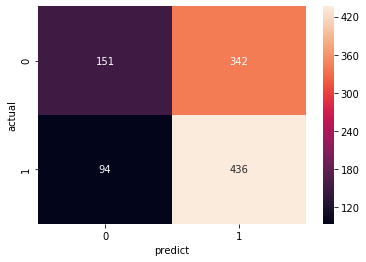

In [70]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

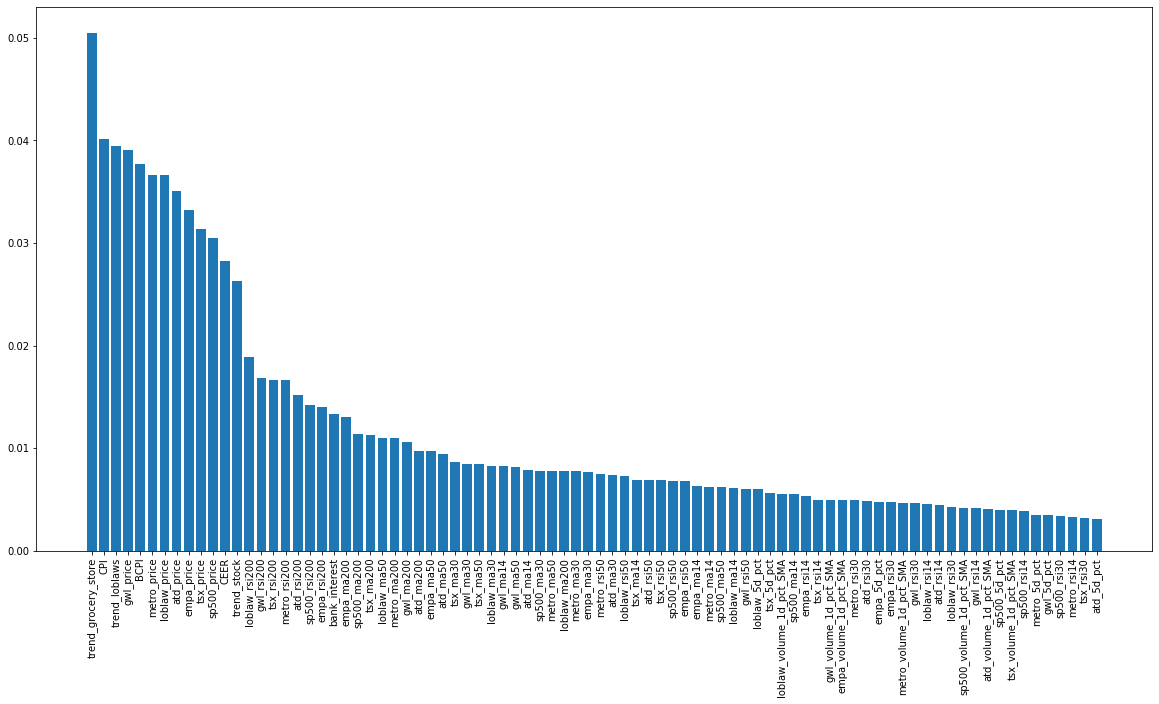

In [66]:
# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.figure(figsize=(20,10))
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [67]:
df.to_csv("data/data_feature_created.csv")

In [68]:
labels

array(['trend_grocery_store', 'CPI', 'trend_loblaws', 'gwl_price', 'BCPI',
       'metro_price', 'loblaw_price', 'atd_price', 'empa_price',
       'tsx_price', 'sp500_price', 'CEER', 'trend_stock', 'loblaw_rsi200',
       'gwl_rsi200', 'tsx_rsi200', 'metro_rsi200', 'atd_rsi200',
       'sp500_rsi200', 'empa_rsi200', 'bank_interest', 'empa_ma200',
       'sp500_ma200', 'tsx_ma200', 'loblaw_ma50', 'metro_ma200',
       'gwl_ma200', 'atd_ma200', 'empa_ma50', 'atd_ma50', 'tsx_ma30',
       'gwl_ma30', 'tsx_ma50', 'loblaw_ma30', 'gwl_ma14', 'gwl_ma50',
       'atd_ma14', 'sp500_ma30', 'metro_ma50', 'loblaw_ma200',
       'metro_ma30', 'empa_ma30', 'metro_rsi50', 'atd_ma30',
       'loblaw_rsi50', 'tsx_ma14', 'atd_rsi50', 'tsx_rsi50',
       'sp500_rsi50', 'empa_rsi50', 'empa_ma14', 'metro_ma14',
       'sp500_ma50', 'loblaw_ma14', 'gwl_rsi50', 'loblaw_5d_pct',
       'tsx_5d_pct', 'loblaw_volume_1d_pct_SMA', 'sp500_ma14',
       'empa_rsi14', 'tsx_rsi14', 'gwl_volume_1d_pct_SMA',
       'em